Grupo:
    
    Nathalia Morales
    Cristian Castillo
    Yuri Kaffaty

# Sequence Modeling 

* Una secuencia es una coleccion de items ordenada
* ML tradicional asume que la data es independiente e identicamente distribuida (IID)
* Data en secuencia: un punto depende en los puntos que lo preceden o lo siguen.
    * Lenguaje: La preposicion "of" es probablemente seguida del articulo "the";
    * por ejemplo, "The lion is the king of the jungle."

### Sequence Modeling en DL

* Involucra mantener un _"hidden state"_
* Mientras procesamos cada item en la secuencia -por ejemplo, cuando cada palabra en una oracion es vista por el modelo- el _hidden state_ se actualiza. 
    * Por tanto, el _hidden state (usualmente un vector) encapsula todo lo que se ha visto en la secuencia hasta ese punto.
* Este vector de _hidden state_ tambien conocido commo _sequence representation_, puede luego ser usado de varias formas dependiendo de la tarea que estamos resolviendo.
    * Clasificar secuencias
    * Predecir secuencias

## Recurrent Neural Networks

* El proposito de RNNs es modelar secuencias de tensores
    * Recuerden que todo puede ser expresado en tensores.
    * En este caso, un RNN esta modelando secuencias de items en pasos de tiempo discreto. ${t-2, t-1, t, t+1, t+2}$
* Hay varios tipos de RNNs:
    * LSTM: Long-Short Term Memory
    * GRU: Gated Recurrent Unit
    * Bi-directional RNN
    * Elman RNN

### Proposito de un RNN

* Aprender una representacion de una secuencia.
* Esto se hace a traves de mantener un _hidden state vector_ que captura el estado actual de la secuencia.
* El _hidden state vector_ es calculado de un _input vector_ actual y el _hidden state vector_ previo.

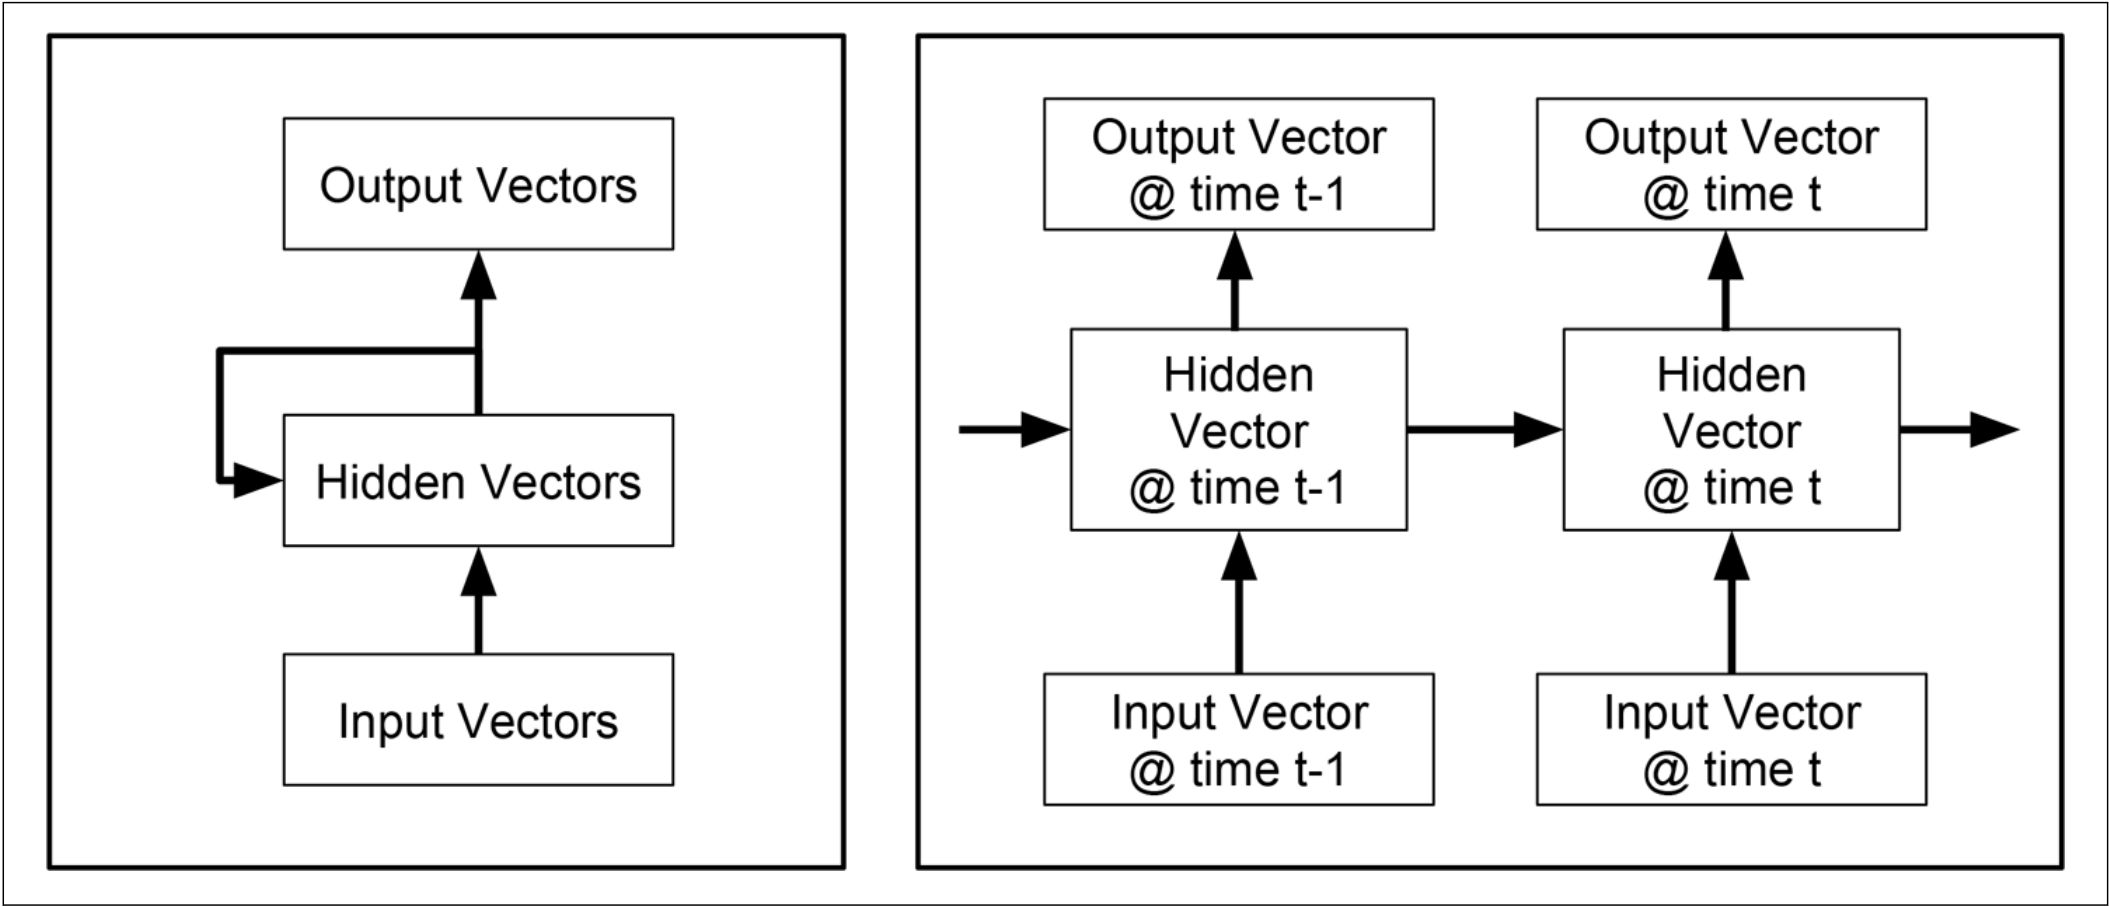

_Dos diferentes vistas del Elman RNN_:
* _izquierda: muestra la relacion recurrente como un feedback loop sobre los hidden vectors_
* _derecha: la vista "desenvuelta" muestra la relacion computacional._
    * _el hidden vector en cada time step es dependiente en el input de ese time step y el hidden vector del time step previo_

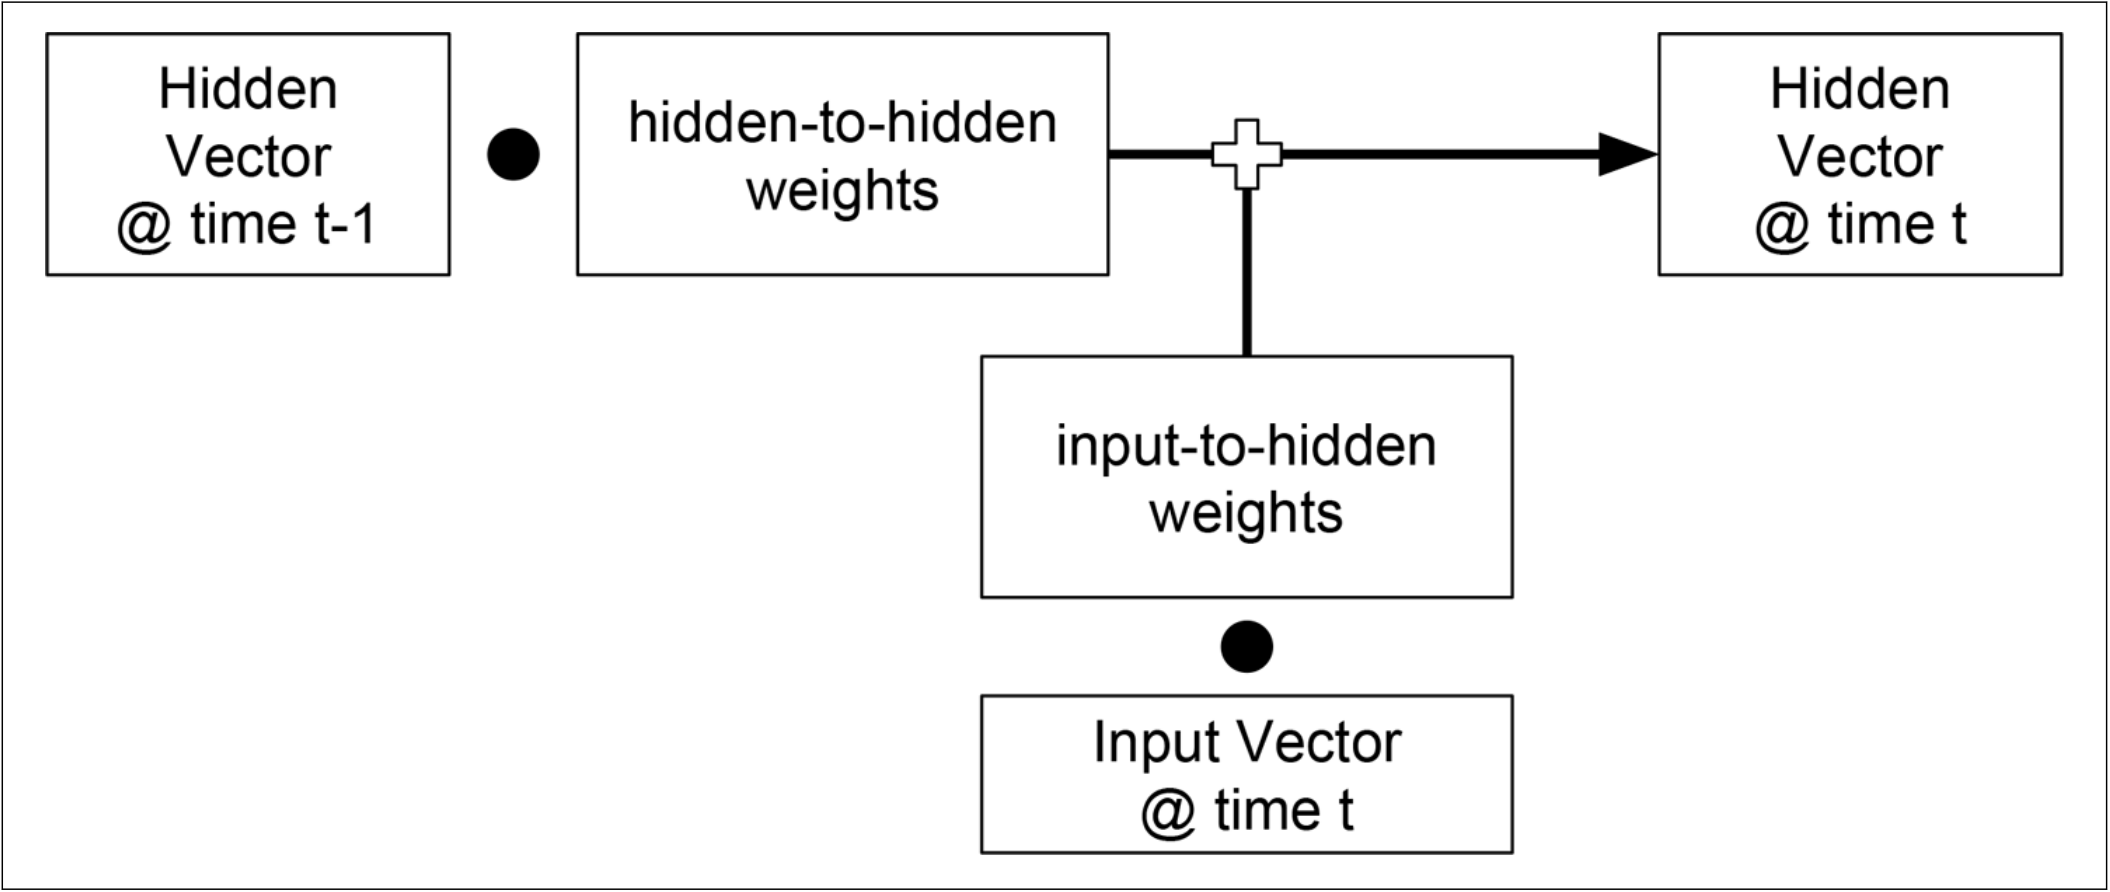

_El calculo explicito que ocurre dentro del Elman RNN_
* _La suma de dos cantidades:_
    * _El producto punto entre el hidden vector del time step previo y un hidden-to-hidden weight matrix_
    * _El producto punto del input vector y un input-to-hidden weight matrix_

## Intuitivamente

* **IMPORTANTE**: Los _hidden-to-hidden_ y _input-to-hidden_ weights se comparten a traves del tiempo.
* Durante el entrenamiento, estos weights van a actualizarse para que el RNN aprenda a: 
    * incorporar informacion entrante
    * mantener un estado que representa un resumen de los inputs vistos hasta ese punto
* El RNN no tiene forma de saber en que time stp esta.
    * En vez, simplemente aprende como transicionar de un time step a otro
    * y mantener un estado que va a minimizar el loss function

### Manejo de Inputs

* Las palabras y las oraciones tienen diferentes largos
* El RNN o cualquier sequence model debe estar equipado para manejar secuencias de largo variable
    1. Restringir secuencias a un tamanio artificial fijo.
    2. Masking: permite a la data senialar cuando ciertos inputs no deberian ser considerados para la gradiente o el output. Para esto, `PyTorch` provee un tipo de dato para manejar secuencias de tamanio variable llamado `PackedSequences`.

## Implementacion de un Elmann RNN

* `PyTorch` provee muchas clases y funciones utiles para construir RNNs.
* La clase `RNN` de `PyTorch` implementa el Elman RNN.
* En vez de utilizar esta clase de forma directa, vamos a usar `RNNCell`:
    * Una abstraccion para un unico time step del RNN y construir un RNN de esto.
* Esto es unicamente con el proposito de demostrar los calculos del RNN de forma explicita.

La siguiente clase, `ElmanRNN` 
* Utiliza el `RNNCell` para:
    * Crear el `input-to-hidden` weight matrix
    * crear el `hidden-to-hidden` weight matrix
* Cada llamada al `RNNCell()` acepta:
    * una matriz de input vectors
    * una matriz de hidden vectors
    * retorna la matriz de hidden vectors que resulta de un time step

In [1]:
#pip install tqdm

In [35]:
#pip install ipywidgets

In [3]:
#pip install ipywidgets
#jupyter nbextension enable --py widgetsnbextension

In [4]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [5]:
class ElmanRNN(nn.Module):
    """ an Elman RNN build using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            batch_first (bool): wether the 0th dimension is batch
        """
        super().__init__()
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.batch_first = batch_first
        self.hidden_size = hidden_size
        
    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))
    
    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        Args:
            x_in (torch.Tensor): an input data tensor.
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step.
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
            
        hiddens = []
        
        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)
            
        hidden_t = initial_hidden
        
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)
        
        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)
            
        return hiddens

**El argumento `batch_first`**

* Adicional a controlar los hiperparametros input y hidden size en el RNN, hay un argumento Booleano para especificar si la dimension del `batch_size` va a estar en la dimension 0.
* Este flag esta presente en todas las implementaciones de RNNs en PyTorch.
* Cuando es `True`, el RNN cambia las dimensiones 0 y 1 en el input tensor.

**El metodo `forward()`**

* hace un loop sobre el input tensor para calcular el hidden state vector por cada time step.
* Noten que hay una opcion para especificar el hidden state inicial, pero si no se provee, un hidden state vector default de 0s es usado.
* Mientras la clase `ElmanRNN` hace un loop sobre el largo del input vector, calcula un nuevo hidden state.
* Estos hidden states se aggregan y al final los apilamos.
* Antes de retornarlos, se revisa el `batch_first` otra vez.
    * Si es `True`, hacemos un `permute` de los output hidden vectors para que el batch este de nuevo en la dimension 0.

**El output de `ElmanRNN`**
* Un tensor 3D
    * un hidden state vector por cada punto de data en la dimension de batch y cada time step.
* Estos hidden vectors pueden usarse de diferentes maneras, dependiendo de la tarea.
* Para clasificar cada time step a un conjunto discreto de opciones.
    * Esto quiere decir que los weights del RNN se van a actualizar para llevar un registro de informacion relevante para predicciones a cada time step.
* Para clasificar la secuencia entera.
    * Esto quiere decir que los weights del RNN se van a ajustar para llevar un registro de informacion importante para la clasificacion eventual.

## Ejemplo: Clasificar la nacionalidad de apellidos usando un Character RNN

### Vocabulary

In [6]:
class Vocabulary:
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]
    

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]
    

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    
    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    
    def __len__(self):
        return len(self._token_to_idx)

### Sequence Vocabulary

In [7]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super().__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)


    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

COMENTARIO
### Para que se necesita el lookup y sequence vocabulary?
COMENTARIO

### Vectorizer

In [8]:
class SurnameVectorizer:
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

        
    def vectorize(self, surname, vector_length=-1):
        """ 
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index] ### QUE HACE AQUI
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname) ### QUE HACE AQUI CON EXTEND?
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices) ### POR QUE SE CAMBIA CON INDICES?

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)

    
    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

### Dataset

In [9]:
### Nota: basicamente asignacion de parametros dentro del proceso (no la funcion)
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
        
### NO ENTIENDO QUE ESTA PASANDO AQUI
    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    
    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

        
    def __len__(self):
        return self._target_size

    
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector, 
                'y_target': nationality_index, 
                'x_length': vec_length}

    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

### Modelo

In [10]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`. ### que se reconoce como un vector entonces???

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index. ### explicacion, pero cual es la diferencia entre un vector y un valor???

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class ElmanRNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens



class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in) ### de donde sale la funcion emb??
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

### Settings

In [11]:
args = Namespace(
    # Data and path information
    surname_csv="../data/surnames/surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=100,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337, ### que es el seed???
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=False
)

In [12]:
args.device = torch.device("cuda" if args.cuda else "cpu")
print(f"Using CUDA: {args.cuda}")

Using CUDA: False


In [13]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

### Training Routine

In [14]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        train_state['stop_early'] = False

    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            if loss_t < train_state['early_stopping_best_val']:
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [15]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

### Compute the loss & accuracy on the test set

In [16]:
classifier = classifier.to(args.device) ### aqui me pierdo de a donde se va a evaluar
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [17]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.8523017406463624;
Test Accuracy: 42.18750000000001


### Inference

In [18]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)
    
    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)
    
    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return {'nationality': predicted_nationality, 'probability': prob_value, 'surname': surname}

In [34]:
classifier = classifier.to("cpu")
for surname in ['McMahan', 'Brown', 'Morales', 'Kaffaty']:
    print(predict_nationality(surname, classifier, vectorizer))

{'nationality': 'Irish', 'probability': 0.621931791305542, 'surname': 'McMahan'}
{'nationality': 'Dutch', 'probability': 0.2907232344150543, 'surname': 'Brown'}
{'nationality': 'Portuguese', 'probability': 0.4296773076057434, 'surname': 'Morales'}
{'nationality': 'English', 'probability': 0.24592234194278717, 'surname': 'Kaffaty'}
